In [16]:
import numpy as np

# Assuming `points` is your numpy array of shape (N, 3) where N is the number of points
points = np.load("/home/sam/sw/chroma-lxe/data/lightmap_points_2.5mm_orthofill.npy")
# Find the min and max coordinates in each dimension
min_coords = points.min(axis=0)
max_coords = points.max(axis=0)

# Define the pitch
pitch = 2.5

# Generate the ranges for each dimension, considering the pitch
x_range = np.arange(min_coords[0], max_coords[0] + pitch, pitch)
y_range = np.arange(min_coords[1], max_coords[1] + pitch, pitch)
z_range = np.arange(min_coords[2], max_coords[2] + pitch, pitch)

In [23]:
# Create a meshgrid of all possible voxel positions
xx, yy, zz = np.meshgrid(x_range, y_range, z_range, indexing="ij")

# Combine the grids to get the final list of voxel positions
voxel_positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

voxel_shape=len(np.unique(voxel_positions[:, 0])), len(np.unique(voxel_positions[:, 1])), len(np.unique(voxel_positions[:,2]))
voxel_shape

(99, 50, 100)

In [19]:
import h5py

with h5py.File("/home/sam/sw/chroma-lxe/data/results/nphoton_scan_2.5mm_orthofill.h5", "r") as f:
    points = np.array([f["posX"], f["posY"], f["posZ"]]).T
    pte = np.array([f[f"ch{i:02d}_pte"] for i in range(9)]).T

point_dict = dict()
for point, pte in zip(points, pte):
    point_dict[tuple(point)] = pte

outside_pos = []
outside_pte = []
for pt in voxel_positions:
    if tuple(pt) not in point_dict:
        point_dict[tuple(pt)] = [0] * 9

In [20]:
from photonlib import VoxelMeta

ranges = np.array(
    [
        [np.min(points[:, 0]) - pitch/2, np.max(points[:, 0]) + pitch/2],
        [np.min(points[:, 1]) - pitch/2, np.max(points[:, 1]) + pitch/2],
        [np.min(points[:, 2]) - pitch/2, np.max(points[:, 2]) + pitch/2],
    ]
).astype(float)

meta = VoxelMeta(shape=np.diff(ranges).ravel() / pitch, ranges=ranges)
meta.idx_to_coord(40)

tensor([-20.0000,  17.5000, -22.5000])

In [22]:
len(meta)

495000

In [13]:
points.min(axis=0), points.max(axis=0)

(array([-120.,  -82., -122.], dtype=float32),
 array([126.,  40., 124.], dtype=float32))

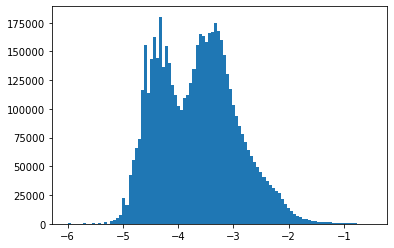

In [16]:
from tqdm import tqdm

num_pmt = 12
vis = np.zeros(shape=(len(meta), num_pmt), dtype=np.float32)

idx = meta.coord_to_voxel(np.array(list(point_dict.keys())))
vis[idx] = np.array(list(point_dict.values()))

import matplotlib.pyplot as plt
plt.hist(np.log10(vis[vis!=0]), bins=100);

In [17]:
from photonlib import PhotonLib

lxeplib = PhotonLib(meta, vis)
PhotonLib.save("/home/sam/sw/chroma-lxe/data/lxeplib_2mm_orthofill_fixed.h5", vis, meta)

[PhotonLib] saving to /home/sam/sw/chroma-lxe/data/lxeplib_2mm_orthofill_fixed.h5
[PhotonLib] file saved


NameError: name 'vis' is not defined

vis

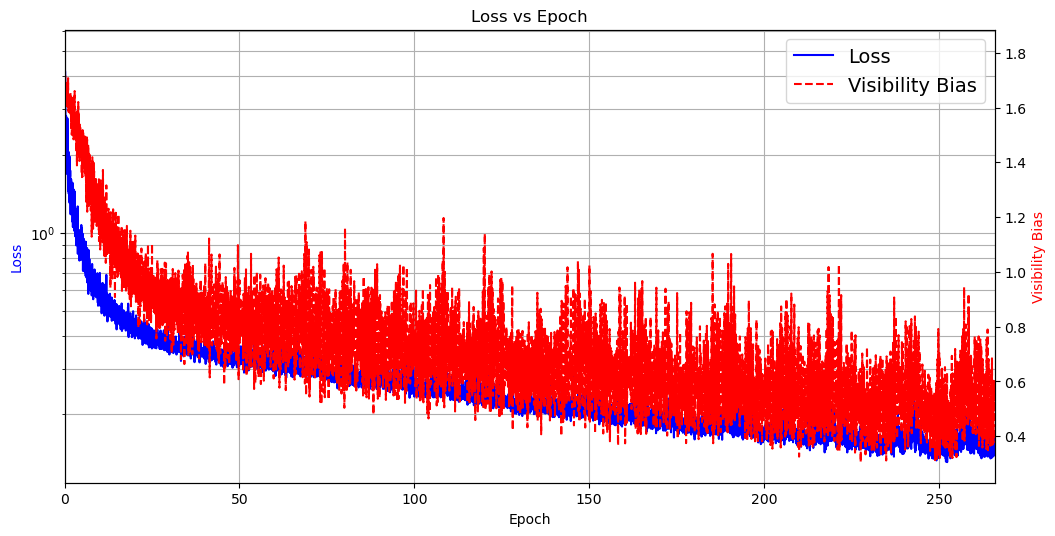

KeyboardInterrupt: 

In [51]:
import time
from IPython.display import clear_output
import pandas as pd

while True:
    clear_output(wait=True)

    csv = pd.read_csv("/home/sam/sw/siren-lartpc/logs_weighted_orthofill/version-07/log2.5mm.csv")
    # csv2 = pd.read_csv("/home/sam/sw/siren-lartpc/logs_weighted/version-01/log.csv")
    
    # # combine the two csvs
    # combined = pd.concat([csv, csv2])
    # csv = combined.sort_values("iter")
    
    # plot the loss
    iter_per_epoch = (csv["epoch"] == 0).sum()
    plt.figure(figsize=(12, 6), dpi=100)
    plt.plot(csv["iter"] / iter_per_epoch, csv["loss"], color="blue")
    plt.xlabel("Epoch")
    plt.ylabel(
        "Loss", color='blue'
    )
    plt.title("Loss vs Epoch")
    plt.xlim(0, csv["iter"].max() / iter_per_epoch)
    plt.yscale("log")
    plt.grid(which="both", axis="both")

    plt.twinx()
    plt.plot(csv["iter"] / iter_per_epoch, csv["vis_bias"], ls="--", color="red")
    plt.ylabel("Visibility Bias", color="red")
    # plt.yscale('log')
    lines = [
        plt.Line2D([0, 1], [1, 1], color="blue"),
        plt.Line2D([0, 1], [1, 1], color="red", ls="--"),
    ]
    plt.legend(lines, ["Loss", "Visibility Bias"], loc="upper right",
               fontsize=14)
    
    plt.show()

    time.sleep(2)